In [8]:
from PIL import Image
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models

import matplotlib.pyplot as plt
from datasets import MixedImgDataset


In [9]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create dataset
dataset = MixedImgDataset(root_dir='./data/MixedImg', transform=transform)

# Check dataset
print(f"Dataset size: {len(dataset)}")
print(f"Classes: {dataset.classes}")
print(f"Class to index mapping: {dataset.class_to_idx}")

Dataset size: 42
Classes: ['Disturbance', 'IF', 'Normal']
Class to index mapping: {'Disturbance': 0, 'IF': 1, 'Normal': 2}


In [10]:
from torch.utils.data import random_split
batch_size = 4
# Define split ratio (e.g., 80% training, 20% testing)
train_ratio = 0.8
test_ratio = 1 - train_ratio

# Calculate lengths
dataset_size = len(dataset)
train_size = int(train_ratio * dataset_size)
test_size = dataset_size - train_size

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create separate dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Print information about the splits
print(f"Total dataset size: {dataset_size}")
print(f"Training set size: {len(train_dataset)}")
print(f"Testing set size: {len(test_dataset)}")

Total dataset size: 42
Training set size: 33
Testing set size: 9


In [11]:
from models import BYOL
from torch import nn

# base_net = nn.Sequential(
#         nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
#         nn.BatchNorm2d(64),
#         nn.ReLU(),
#         nn.AdaptiveAvgPool2d((1, 1)),
#         nn.Flatten(),
#         nn.Linear(64, 128),
#         nn.ReLU(),
#         nn.Linear(128, 128),
#         nn.ReLU(),
#         nn.Linear(128, 64),
#         nn.ReLU(),
#         nn.Linear(64, 32),
#         nn.ReLU(),
#         nn.Linear(32, 3),
#     )


# Initialize ResNet18
base_net = models.resnet18(pretrained=True)

# Modify the final layer to output 3 classes
num_features = base_net.fc.in_features
base_net.fc = nn.Linear(num_features, 3)

# Print model structure to verify
print(f"ResNet18 output dimension: {base_net.fc.out_features}")
print(f"Number of parameters: {sum(p.numel() for p in base_net.parameters())}")

# Visualize the architecture of the last few layers
for name, module in list(base_net.named_children())[-4:]:
    print(f"{name}: {module}")

ResNet18 output dimension: 3
Number of parameters: 11178051
layer3: Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(

/home/xiangyu/.conda/envs/PyTc/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/xiangyu/.conda/envs/PyTc/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
# 设置设备，优先使用 GPU（如果可用）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 实例化简化后的 BYOL 模型，hidden_layer=-2 表示取倒数第二层的输出作为隐藏表示
model = BYOL(net=base_net, hidden_layer=-2, projection_size=3, projection_hidden_size=32).to(device)
model.train()

# 超参数设置
epochs = 200
batch_size = 4
learning_rate = 1e-4

# 定义优化器
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 训练循环
for epoch in range(epochs):
    running_loss = 0.0
    for batch_idx, (data, _) in enumerate(train_dataloader):
        if data.size(0) < 2:
            continue
        data = data.to(device)
        optimizer.zero_grad()
        
        # 前向传播：model(data) 返回 (projection, representation)
        projection, representation = model(data)
        
        # 此处定义一个简单的损失函数：投影输出的 L2 范数
        # 仅作为示例，实际任务中可根据需要设计损失函数
        loss = projection.norm()
        
        # 反向传播和参数更新
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{epochs}], Step [{batch_idx+1}/{len(train_dataloader)}], Loss: {running_loss/100:.4f}')
        running_loss = 0.0
        # Save the model checkpoint
torch.save(model.state_dict(), f'byol_model.pth')

print('Training completed.')

Epoch [1/200], Step [1/9], Loss: 0.0119
Epoch [1/200], Step [2/9], Loss: 0.0139
Epoch [1/200], Step [3/9], Loss: 0.0130
Epoch [1/200], Step [4/9], Loss: 0.0094
Epoch [1/200], Step [5/9], Loss: 0.0127
Epoch [1/200], Step [6/9], Loss: 0.0138
Epoch [1/200], Step [7/9], Loss: 0.0137
Epoch [1/200], Step [8/9], Loss: 0.0130
Epoch [2/200], Step [1/9], Loss: 0.0139
Epoch [2/200], Step [2/9], Loss: 0.0113
Epoch [2/200], Step [3/9], Loss: 0.0113
Epoch [2/200], Step [4/9], Loss: 0.0099
Epoch [2/200], Step [5/9], Loss: 0.0109
Epoch [2/200], Step [6/9], Loss: 0.0095
Epoch [2/200], Step [7/9], Loss: 0.0097
Epoch [2/200], Step [8/9], Loss: 0.0087
Epoch [3/200], Step [1/9], Loss: 0.0108
Epoch [3/200], Step [2/9], Loss: 0.0098
Epoch [3/200], Step [3/9], Loss: 0.0084
Epoch [3/200], Step [4/9], Loss: 0.0098
Epoch [3/200], Step [5/9], Loss: 0.0076
Epoch [3/200], Step [6/9], Loss: 0.0098
Epoch [3/200], Step [7/9], Loss: 0.0089
Epoch [3/200], Step [8/9], Loss: 0.0091
Epoch [4/200], Step [1/9], Loss: 0.0091


Testing the model...
Accuracy: 0.2424
Recall: 0.2424
F1 Score: 0.1564

Classification Report:
              precision    recall  f1-score   support

 Disturbance       0.00      0.00      0.00        13
          IF       0.38      0.80      0.52        10
      Normal       0.00      0.00      0.00        10

    accuracy                           0.24        33
   macro avg       0.13      0.27      0.17        33
weighted avg       0.12      0.24      0.16        33



/home/xiangyu/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/xiangyu/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/xiangyu/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


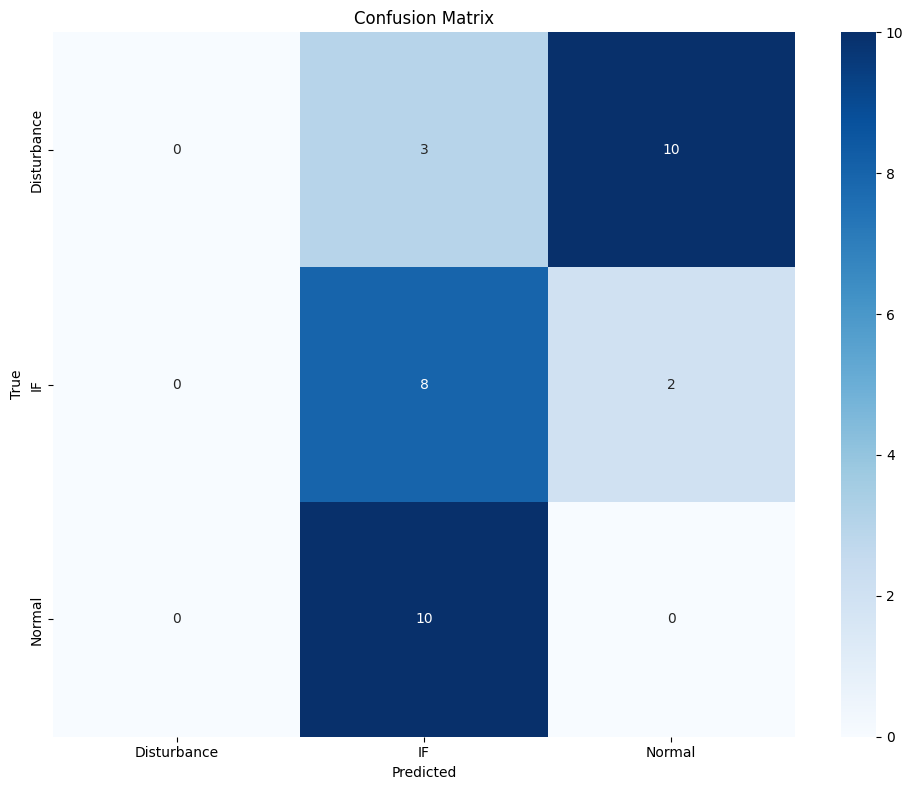

In [13]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Test the model's performance
model.eval()
all_preds = []
all_labels = []

print("Testing the model...")

with torch.no_grad():
    for images, labels in train_dataloader:  # Using test_dataloader instead of train_dataloader
        images = images.to(device)
        labels = labels.to(device)
        
        # Extract features using the online encoder
        # BYOL model returns both projection and representation, but we need representation
        projection, representation = model(images)
        
        # Use the last layer output as logits for classification
        preds = torch.argmax(projection, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=dataset.classes))

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=dataset.classes, 
            yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


In [14]:
all_labels, all_preds

(array([0, 2, 1, 0, 0, 1, 0, 2, 2, 0, 2, 0, 0, 2, 1, 1, 0, 0, 1, 0, 2, 2,
        1, 1, 1, 1, 2, 0, 2, 0, 1, 2, 0]),
 array([1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1,
        1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2]))